In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os 



num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("D:/PetImages/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)



image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "D:/PetImages/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)



Deleted 0 images
Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


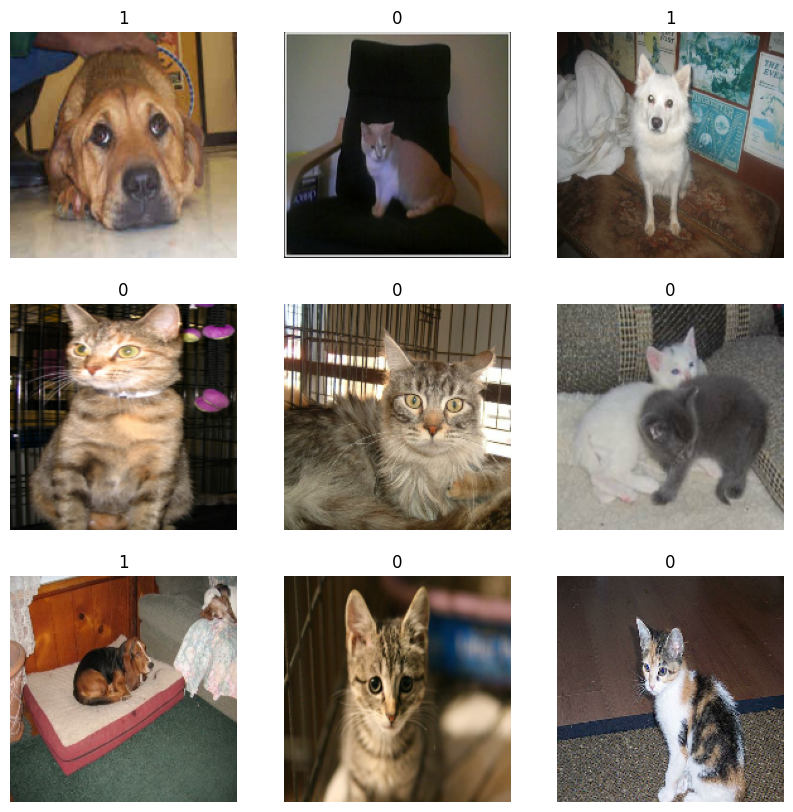

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

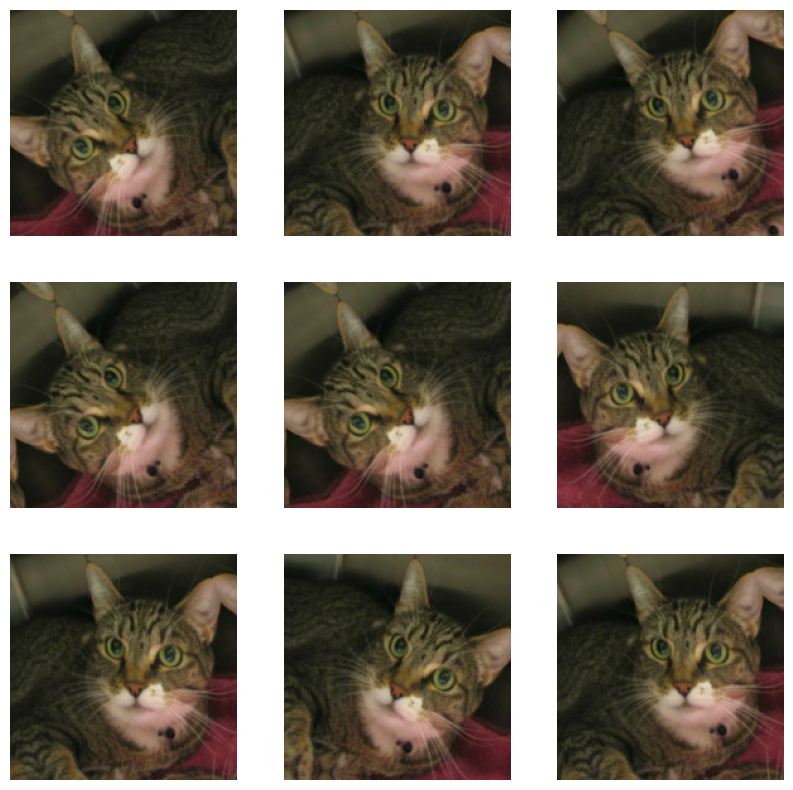

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [15]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [16]:


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/separable_conv2d_9/separable_conv2d/depthwise' defined at (most recent call last):
    File "c:\Users\USER\.conda\envs\machine_learning\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\USER\.conda\envs\machine_learning\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\USER\.conda\envs\machine_learning\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_8908\2660810289.py", line 11, in <module>
      model.fit(
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\separable_conv2d.py", line 188, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model_1/separable_conv2d_9/separable_conv2d/depthwise'
OOM when allocating tensor with shape[128,45,45,256] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model_1/separable_conv2d_9/separable_conv2d/depthwise}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11818]